#### Asset 5 Error Code -> LSTM -> Accuracy

In [2]:
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
pd.options.mode.chained_assignment = None
import random as rn
import os
import numpy as np
from numpy import array
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from sklearn import preprocessing

import tensorflow as tf
from keras.utils import to_categorical

from time import time
import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
import pydot

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting Seed for reproducibility.
sd = 1 # Here sd means seed.
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

import warnings
warnings.filterwarnings('always')

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

Using TensorFlow backend.


In [3]:
df_5 = pd.read_csv('Asset5_ErrorCode.csv')

In [4]:
df_5 = df_5.copy()

In [5]:
df_5.head()

,DateTime,ErrorCode,FlowTime,Amount,Litres,Voltage,FxRate,FlowRate
0,2004-01-01 01:35:09,9,66,19,32.391667,5.578702,0.025,29.446970
1,2004-01-01 01:38:00,9,22,6,10.547222,5.578702,0.025,28.765152
2,2004-01-01 01:39:02,9,2,0,0.444444,5.578702,0.025,13.333333
3,2004-01-01 03:38:07,9,2,0,0.422222,5.578702,0.025,12.666667
4,2004-01-01 03:39:09,9,42,12,19.869444,5.578702,0.025,28.384921


#### Check unique Error Code values

In [6]:
df_5.ErrorCode.value_counts()

9     39797
17     1276
6      1070
5       723
24      704
1       638
14      506
16      245
15      206
11       27
18       21
23        5
7         1
2         1
Name: ErrorCode, dtype: int64

In [7]:
df_5.ErrorCode.nunique()

14

#### Remove the single occurence of Error Code to ensure proper class balance in each data split

In [8]:
df_5 = df_5[df_5.ErrorCode != 7]

In [9]:
df_5 = df_5[df_5.ErrorCode != 2]

In [10]:
df_5.ErrorCode.nunique()

12

#### Split Train/Test data from main Asset file

In [11]:
train, test = train_test_split(df_5, test_size=0.3, random_state=42, shuffle=True)

In [12]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

In [13]:
train.shape, test.shape

((31652, 7), (13566, 7))

In [14]:
trainX = train.drop('ErrorCode', axis=1)
testX = test.drop('ErrorCode', axis=1)

In [15]:
trainy = train.drop(['FlowTime', 'Amount', 'Litres', 'Voltage', 'FxRate', 'FlowRate'], axis=1)
testy = test.drop(['FlowTime', 'Amount', 'Litres', 'Voltage', 'FxRate', 'FlowRate'], axis=1)

In [16]:
trainX.shape, trainy.shape

((31652, 6), (31652, 1))

In [17]:
testX.shape, testy.shape

((13566, 6), (13566, 1))

#### Split data to obtain Validation data set (20 % used as validation)

In [18]:
trainX, valX, trainy, valy = train_test_split(trainX, trainy, test_size=0.2, random_state=32, shuffle=True)

In [19]:
valX.shape, valy.shape

((6331, 6), (6331, 1))

#### Check if the number of classes look similar to earlier results

In [20]:
valy.ErrorCode.unique()

array([ 9,  5, 24,  6, 14, 16,  1, 15, 17, 11, 18])

In [21]:
valy.ErrorCode.nunique()

11

#### Convert all classes in all data splits to categorical

In [22]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)
valy = to_categorical(valy)

In [23]:
trainy.shape, testy.shape, valy.shape

((25321, 25), (13566, 25), (6331, 25))

#### Helper function to split data into suitable timesteps (30 timesteps/hours are used) 

In [24]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#### Train data splitting

In [25]:
trainX = np.array(trainX) 
trainy = np.array(trainy)

In [26]:
trainX, _ = split_sequence(trainX, 30)
_, trainy = split_sequence(trainy, 30)

In [27]:
trainX.shape, trainy.shape

((25291, 30, 6), (25291, 25))

#### Test data splitting

In [28]:
testX = np.array(testX) 
testy = np.array(testy)

In [29]:
testX, _ = split_sequence(testX, 30)
_, testy = split_sequence(testy, 30)

In [30]:
testX.shape, testy.shape

((13536, 30, 6), (13536, 25))

#### Validation data splitting

In [31]:
valX = np.array(valX) 
valy = np.array(valy)

In [32]:
valX, _ = split_sequence(valX, 30)
_, valy = split_sequence(valy, 30)

In [33]:
valX.shape, valy.shape

((6301, 30, 6), (6301, 25))

#### Custom Keras metric to calculate Recall, Precision and F1 Score

In [34]:
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

#### Define model architecture

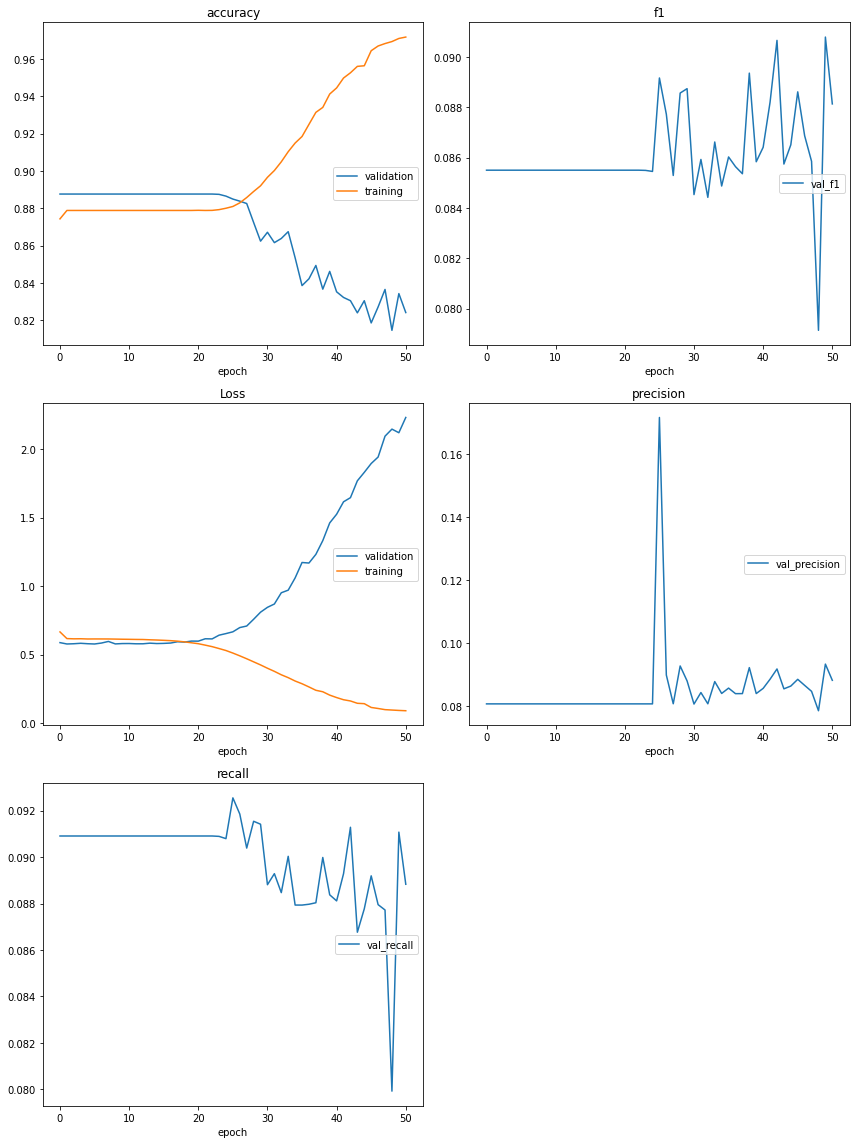

accuracy
	validation       	 (min:    0.815, max:    0.888, cur:    0.824)
	training         	 (min:    0.874, max:    0.972, cur:    0.972)
f1
	val_f1           	 (min:    0.079, max:    0.091, cur:    0.088)
Loss
	validation       	 (min:    0.577, max:    2.232, cur:    2.232)
	training         	 (min:    0.089, max:    0.665, cur:    0.089)
precision
	val_precision    	 (min:    0.079, max:    0.172, cur:    0.088)
recall
	val_recall       	 (min:    0.080, max:    0.093, cur:    0.089)
Epoch 00051: early stopping


Training time in minutes: 55.30


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           42800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)       

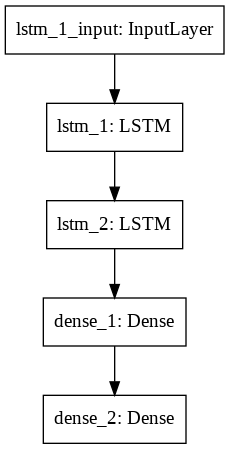

In [35]:
verbose, epochs, batch_size = 1, 200, 64
n_nodes = 100

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

# Early stopping and Model checkpointing
es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=50, min_delta=1)
mc = ModelCheckpoint('Asset_5_best_model_LSTM-ErrorCode.h5', monitor='val_f1', mode='max', verbose=1, save_best_only=True)

model = Sequential()
model.add(LSTM(n_nodes, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(n_nodes))
#model.add(Dropout(0.5))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit network
start = time()

model.fit(trainX, trainy, validation_data=(valX, valy), epochs=epochs, batch_size=batch_size, verbose=verbose, 
          callbacks=[Metrics(valid_data=(valX, valy)), es, mc, PlotLossesKeras()])

print('\n')
print('Training time in minutes: %.2f' % ((time() - start) / 60))
print('\n')
model.summary()
keras.utils.vis_utils.pydot = pydot
plot_model(model, to_file='Asset_5_Architecture_LSTM-ErrorCode.png')

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(testX, testy, verbose=0)

print('Accuracy: %f' % accuracy)
print('Loss: %f' % loss)

Accuracy: 0.815086
Loss: 2.478243


#### Using trained model to score testX data

In [37]:
testX.shape

(13536, 30, 6)

In [38]:
# Predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)

In [39]:
yhat_probs_decoded = np.argmax(yhat_probs, axis=-1)

In [40]:
yhat_probs_decoded[:5]

array([9, 6, 9, 6, 9])

yhat_probs_decoded -> Shows the first 5 samples of predicted Error Code classes for testX data.

#### ROC AUC Computation

In [41]:
# ROC AUC Computation
#print('ROC AUC Macro: %f' % roc_auc_score(y_true=testy, y_score=yhat_probs, average='macro')) # --> Macro will not work if there's only one class present in y_true.
print('ROC AUC Micro: %f' % roc_auc_score(y_true=testy, y_score=yhat_probs, average='micro'))
print('ROC AUC Samples: %f' % roc_auc_score(y_true=testy, y_score=yhat_probs, average='samples'))

ROC AUC Micro: 0.968788
ROC AUC Samples: 0.971149


#### Load Saved Model

In [42]:
from keras.models import load_model
custom_obj = {'Metrics':Metrics}

model_LSTM = load_model('Asset_5_best_model_LSTM-ErrorCode.h5', custom_objects=custom_obj)

#### Prediction activity using previous timesteps

In [43]:
Asset_5 = pd.read_csv('Asset5_ErrorCode.csv', header=0, index_col=0)
Asset_5_x_input = Asset_5.tail(100)

In [44]:
Asset_5_x_input = Asset_5_x_input.drop('ErrorCode', axis=1)

In [45]:
Asset_5_x_input.head()

,FlowTime,Amount,Litres,Voltage,FxRate,FlowRate
DateTime,,,,,,
2018-07-09 00:33:56,75,9,24.313889,13.12,0.025,19.451111
2018-07-09 00:35:19,80,10,25.641667,13.12,0.025,19.231250
2018-07-09 00:49:31,44,5,13.616667,13.12,0.025,18.568182
2018-07-09 00:54:11,33,4,10.427778,13.12,0.025,18.959596
2018-07-09 01:00:57,37,5,12.238889,13.12,0.025,19.846847


In [46]:
Asset_5_x_input = Asset_5_x_input.values

In [47]:
Asset_5_x_input, _ = split_sequence(Asset_5_x_input, 30)

In [48]:
print(np.asarray(Asset_5_x_input).shape)

(70, 30, 6)


In [49]:
Asset_5_x_input = np.array(Asset_5_x_input)

#### Probabilities of all predictions

In [50]:
Asset_5_yhat = model_LSTM.predict(Asset_5_x_input, verbose=0)
Asset_5_yhat

array([[3.8879855e-25, 3.8507912e-09, 6.7749914e-26, ..., 3.5504742e-27,
        1.1213454e-13, 7.5023268e-06],
       [7.7276646e-33, 6.2657985e-09, 9.0036209e-34, ..., 1.4511087e-35,
        3.7401955e-16, 3.7640299e-07],
       [9.5333451e-18, 1.9697367e-05, 7.9954252e-18, ..., 1.8727495e-18,
        2.6985940e-12, 3.3214320e-07],
       ...,
       [4.4054605e-18, 1.6049287e-10, 1.3505575e-18, ..., 3.0239691e-19,
        2.8656988e-14, 1.7727526e-08],
       [1.5899373e-15, 3.6704762e-06, 1.2727545e-15, ..., 1.3312115e-16,
        1.8446669e-10, 3.7002560e-06],
       [4.6656785e-15, 2.9807572e-07, 5.5134111e-15, ..., 5.8279419e-16,
        1.7926768e-10, 9.0109927e-05]], dtype=float32)

In [51]:
Asset_5_yhat.shape

(70, 25)

#### Convert all prediction probabilities to actual Error Codes

In [52]:
np.argmax(Asset_5_yhat, axis=-1).shape

(70,)

In [53]:
np.argmax(Asset_5_yhat, axis=-1)

array([ 9,  9,  5,  5,  9,  9,  5,  5,  9,  9, 14, 14,  9,  9,  9,  9,  9,
        9,  5,  9,  9, 17,  9, 16,  9, 14,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  5,  9,  9,  9,  9, 14,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 17,  9,  9,  9,  9,  5,  9,
        9,  9])